In [1]:
import os
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
from glob import glob
from random import randint
import cv2
from pathlib import Path
import torch.nn as nn
from torch import optim
from matplotlib import pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
id2int = {'Parasitized': 0, 'Uninfected': 1}

In [3]:
from torchvision import transforms as T

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ColorJitter(brightness=(0.95,1.05),
                  contrast=(0.95,1.05),
                  saturation=(0.95,1.05),
                  hue=0.05),
    T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]),
])

In [4]:
val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]),
])

In [5]:
class MalariaImages(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = os.path.basename(Path(fpath).parent)
        img = cv2.imread(fpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img, clss

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        _imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in _imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes, _imgs

In [6]:
all_files = glob('D:\pycharm\DL-Pytorch\Dataset\cell_images\cell_images\*\*.png')
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = MalariaImages(trn_files, transform=trn_tfms)
val_ds = MalariaImages(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

In [7]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )

class MalariaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 256),
            convBlock(256, 512),
            convBlock(512, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return loss, acc

In [8]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, labels, _ = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, labels, _ = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

In [9]:
model = MalariaClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 5

for ex in range(n_epochs):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        train_loss.append(loss)
        train_acc.append(acc)
    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        val_loss.append(loss)
        val_acc.append(acc)
    avg_train_loss = np.average(train_loss)
    avg_train_acc = np.average(train_acc)
    avg_val_loss = np.average(val_loss)
    avg_val_acc = np.average(val_acc)
    print(f"EPOCH: {ex}	trn_loss: {avg_train_loss}	trn_acc: {avg_train_acc}	val_loss: {avg_val_loss}	val_acc: {avg_val_acc}")

EPOCH: 0	trn_loss: 0.22196048860014314	trn_acc: 0.9215847523219814	val_loss: 0.18273890308207935	val_acc: 0.9466145833333334
EPOCH: 1	trn_loss: 0.16964497835874187	trn_acc: 0.9449358691372001	val_loss: 0.15801186150767738	val_acc: 0.9479166666666666
EPOCH: 2	trn_loss: 0.1578868092124238	trn_acc: 0.9483290026800552	val_loss: 0.16291164182540444	val_acc: 0.9497974537037037
EPOCH: 3	trn_loss: 0.15688875365293017	trn_acc: 0.9493448695531201	val_loss: 0.14149939881948134	val_acc: 0.9516782407407407
EPOCH: 4	trn_loss: 0.15003232733597374	trn_acc: 0.9513627820339734	val_loss: 0.23241227061522227	val_acc: 0.9473379629629629


In [10]:
im2fmap = nn.Sequential(*(list(model.model[:5].children()) + list(model.model[5][:2].children())))

In [11]:
def im2gradCAM(x):
    model.eval()
    logits = model(x)
    heatmaps = []
    activations = im2fmap(x)
    print(activations.shape)
    pred = logits.max(-1)[-1]
    # 获取模型预测
    model.zero_grad()
    # 计算相对于模型置信度最高的 logits 的梯度
    logits[0,pred].backward(retain_graph=True)
    # 获取所需特征图位置的梯度，并对每个特征图取平均梯度
    pooled_grads = model.model[-6][1].weight.grad.data.mean((1,2,3))
    # 将每个激活图与对应的梯度平均值相乘
    for i in range(activations.shape[1]):
        activations[:,i,:,:] *= pooled_grads[i]
    # 计算所有加权激活图的平均值
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, 'Uninfected' if pred.item() else 'Parasitized'

In [12]:
SZ = 120
def upsampleHeatmap(map, img):
    m,M = map.min(), map.max()
    map = 255 * ((map-m) / (M-m))
    map = np.uint8(map)
    map = cv2.resize(map, (SZ,SZ))
    map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
    map = np.uint8(map)
    map = np.uint8(map*0.7 + img*0.3)
    return map

torch.Size([1, 64, 4, 4])


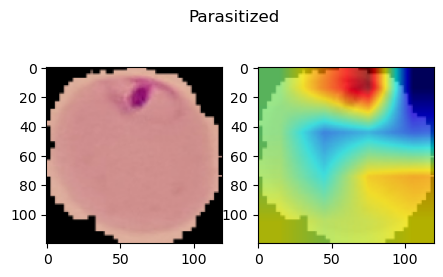

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


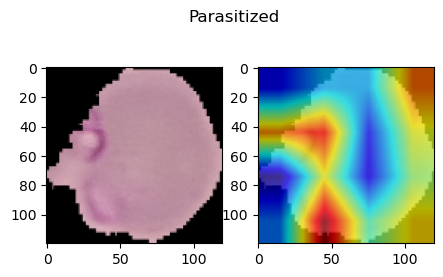

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


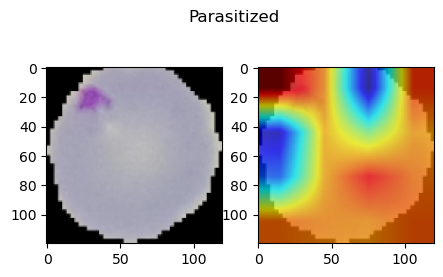

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


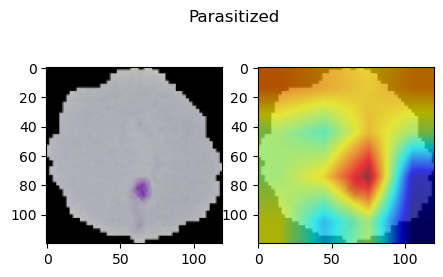

torch.Size([1, 64, 4, 4])


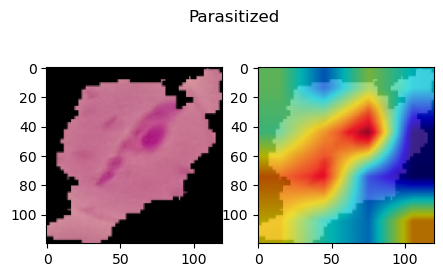

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


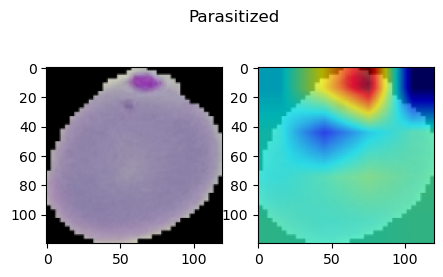

torch.Size([1, 64, 4, 4])


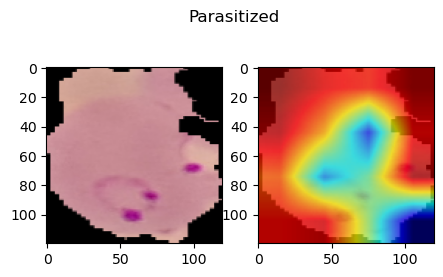

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


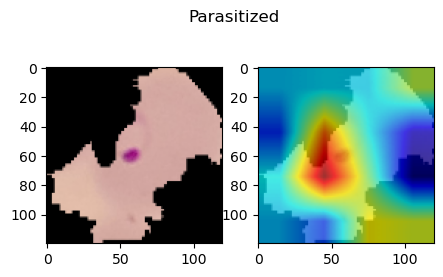

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


In [13]:
N = 20
_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
x,y,z = next(iter(_val_dl))

for i in range(N):
    image = cv2.resize(z[i], (SZ, SZ))
    heatmap, pred = im2gradCAM(x[i:i+1])
    if(pred=='Uninfected'):
        continue
    heatmap = upsampleHeatmap(heatmap, image)
    plt.figure(figsize=(5,3))
    plt.subplot(121)
    plt.imshow(image)
    plt.subplot(122)
    plt.imshow(heatmap)
    plt.suptitle(pred)
    plt.show()